# Regression with an Abalone Dataset - Improved

## 1. Introduction

This notebook aims to predict the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. 

This notebook will follow a structured approach:
1. **Exploratory Data Analysis (EDA):** Understand the data and its characteristics.
2. **Feature Engineering:** Create new features to improve model performance.
3. **Model Selection:** Train and compare different regression models.
4. **Hyperparameter Tuning:** Fine-tune the best model.
5. **Submission:** Generate the submission file.

## 2. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

## 3. Load Data

In [2]:
train_df = pd.read_csv('Regression with an Abalone Dataset/train.csv')
test_df = pd.read_csv('Regression with an Abalone Dataset/test.csv')
sample_submission_df = pd.read_csv('Regression with an Abalone Dataset/my_submission.csv')

print('Train data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

Train data shape: (90615, 10)
Test data shape: (60411, 9)


In [3]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
test_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


The column names in the provided dataset have some inconsistencies (`Whole weight`, `Whole weight.1`, `Whole weight.2`). Let's rename them to be more descriptive based on the original Abalone dataset description from the UCI repository. The correct names are `Shucked weight`, `Viscera weight`, and `Shell weight`. The target variable is `Rings`.

In [5]:
train_df.rename(columns={'Whole weight': 'Whole_weight', 
                             'Whole weight.1': 'Shucked_weight', 
                             'Whole weight.2': 'Viscera_weight', 
                             'Shell weight': 'Shell_weight'}, inplace=True)

test_df.rename(columns={'Whole weight': 'Whole_weight', 
                            'Whole weight.1': 'Shucked_weight', 
                            'Whole weight.2': 'Viscera_weight', 
                            'Shell weight': 'Shell_weight'}, inplace=True)

# Also, let's add the 'Rings' column to the test set with NaN values for consistency
test_df['Rings'] = np.nan

## 4. Exploratory Data Analysis (EDA)

### 4.1. Target Variable Distribution

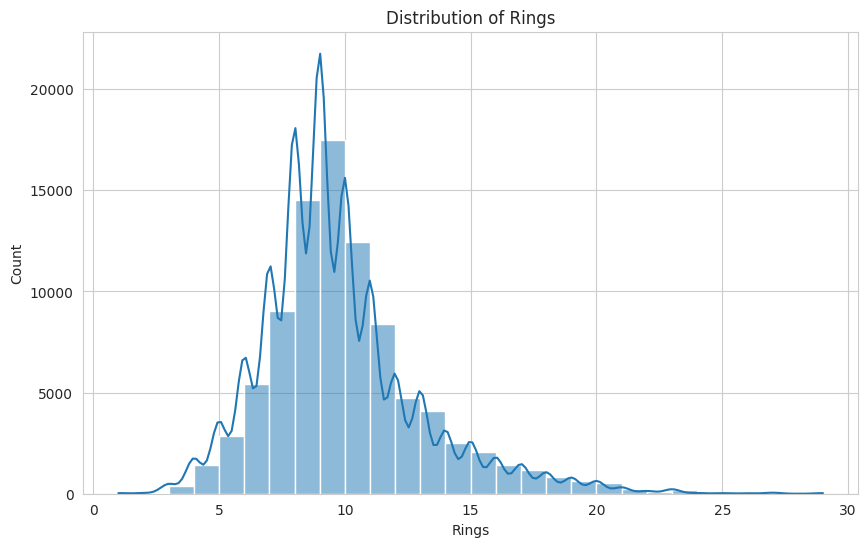

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Rings'], bins=28, kde=True)
plt.title('Distribution of Rings')
plt.show()

### 4.2. Numerical Features Distribution

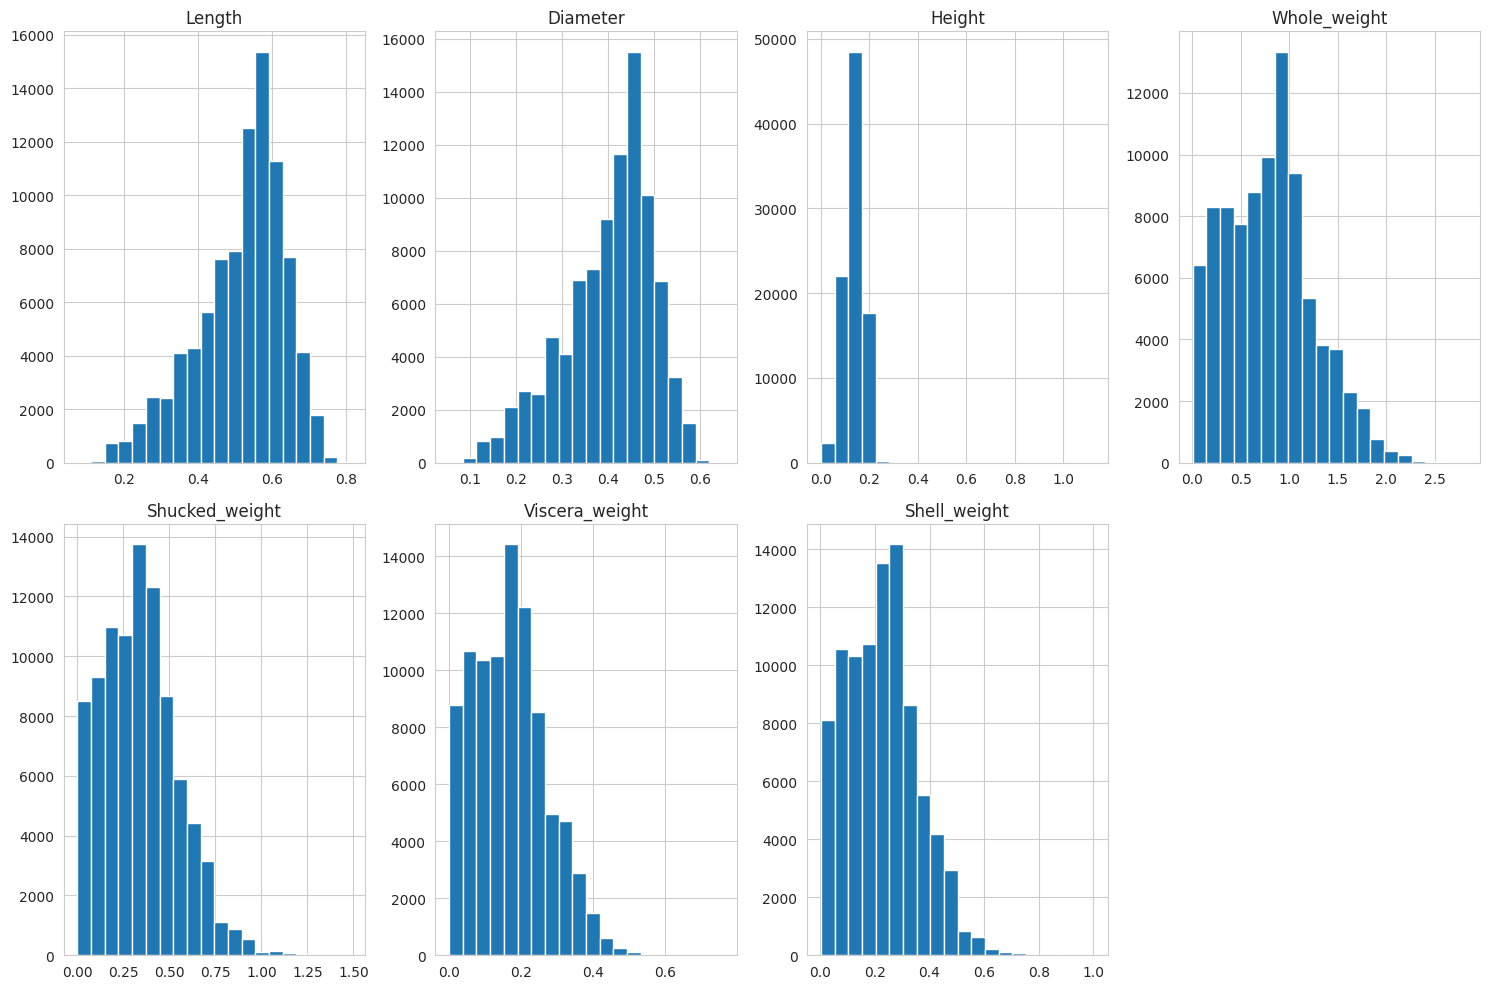

In [7]:
numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('id')
numerical_features.remove('Rings')

train_df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(2, 4))
plt.tight_layout()
plt.show()

### 4.3. Categorical Feature Distribution

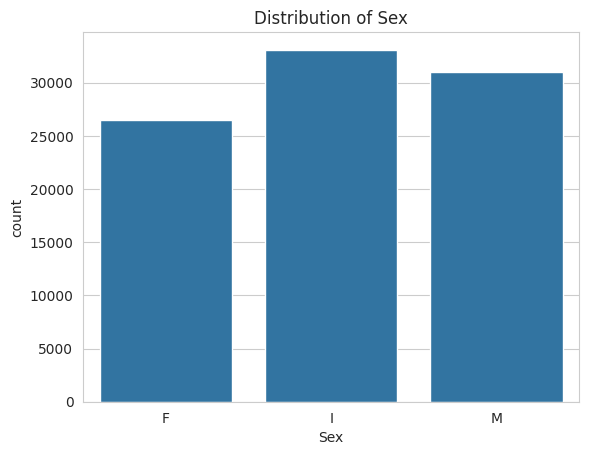

In [8]:
sns.countplot(x='Sex', data=train_df)
plt.title('Distribution of Sex')
plt.show()

### 4.4. Correlation Matrix

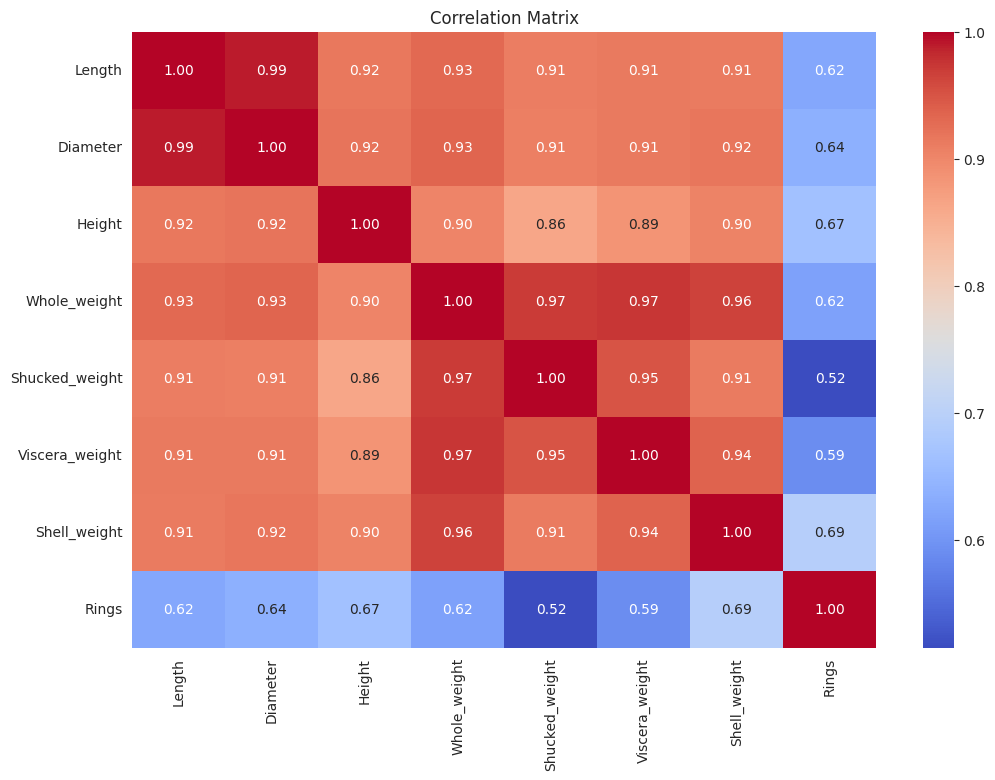

In [9]:
plt.figure(figsize=(12, 8))
corr_matrix = train_df[numerical_features + ['Rings']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 5. Feature Engineering

In [10]:
def feature_engineer(df):
    # One-hot encode the 'Sex' column
    df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
    
    # Create ratio features
    df['crab_area'] = df['Length'] * df['Diameter']
    df['approx_density'] = df['Whole_weight'] / (df['crab_area'] * df['Height'])
    df['bmi'] = df['Whole_weight'] / (df['Height']**2)
    
    # Interaction features
    df['length_dia_ratio'] = df['Length'] / df['Diameter']
    df['length_height_ratio'] = df['Length'] / df['Height']
    df['dia_height_ratio'] = df['Diameter'] / df['Height']
    df['shell_shuck_ratio'] = df['Shell_weight'] / df['Shucked_weight']

    # Replace infinities with NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Water loss
    df['water_loss'] = df['Whole_weight'] - df['Shucked_weight'] - df['Viscera_weight'] - df['Shell_weight']
    
    return df

train_featured_df = feature_engineer(train_df.copy())
test_featured_df = feature_engineer(test_df.copy())

print('Train featured shape:', train_featured_df.shape)
print('Test featured shape:', test_featured_df.shape)

Train featured shape: (90615, 19)
Test featured shape: (60411, 19)


## 6. Model Training and Evaluation

In [11]:
X = train_featured_df.drop(['id', 'Rings'], axis=1)
y = train_featured_df['Rings']
X_test_final = test_featured_df.drop(['id', 'Rings'], axis=1)

# Align columns - crucial for consistent feature sets
train_cols = X.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X[c] = 0

X_test_final = X_test_final[train_cols]

# Impute any remaining NaNs
X.fillna(X.median(), inplace=True)
X_test_final.fillna(X_test_final.median(), inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

### 6.1. Model Comparison

In [13]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    # Predictions can't be negative
    y_pred[y_pred < 0] = 0
    score = rmsle(y_val, y_pred)
    results[name] = score
    print(f'{name} RMSLE: {score:.5f}')

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSLE']).sort_values('RMSLE')
print('\nModel Comparison:')
print(results_df)

RandomForest RMSLE: 0.15649


GradientBoosting RMSLE: 0.15437


XGBoost RMSLE: 0.15408

Model Comparison:
              Model     RMSLE
2           XGBoost  0.154080
1  GradientBoosting  0.154366
0      RandomForest  0.156494


### 6.2. Hyperparameter Tuning (for the best model)

In [14]:
# Let's assume XGBoost is the best model based on the above results
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                                   n_iter=20, cv=3, verbose=2, random_state=42, 
                                   n_jobs=-1, scoring='neg_mean_squared_log_error')

random_search.fit(X_train_scaled, y_train)

print('Best parameters found: ', random_search.best_params_)

best_xgb = random_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_val_scaled)
y_pred_tuned[y_pred_tuned < 0] = 0
tuned_rmsle = rmsle(y_val, y_pred_tuned)

print(f'Tuned XGBoost RMSLE: {tuned_rmsle:.5f}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Tuned XGBoost RMSLE: 0.15223


## 7. Submission

In [15]:
final_predictions = best_xgb.predict(X_test_final_scaled)
final_predictions[final_predictions < 0] = 0

# The predictions are float, but the submission requires integers for Rings
final_predictions = np.round(final_predictions).astype(int)

submission_df = pd.DataFrame({'id': test_df['id'], 'Rings': final_predictions})
submission_df.to_csv('submission.csv', index=False)

print('Submission file created successfully!')
submission_df.head()

Submission file created successfully!


,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,11
4,90619,8
